# Introduction to predictive modelling with logistic regression

Be sure to check out the interactive visualized version of the analysis under <b>xxx</b>!

## Introduction

Predictive modelling means predicting outcomes using statistical techniques. It  can be used both for predicting future events as well as outcomes that have already taken place but are uknown to observer. Predictive modelling is widely used in academic research but also in everyday phenomena. Examples include, but are not limited, to

- detecting crimes
- quantifying risk, e.g. in financial credit risk modelling
- recommendation engines, such as ones used by Netflix and Google
- in medicine detecting patients with fatal deseases

This article is an introduction to predictive modelling. We are going to walk through all the steps in the modelling pipeline, including problem statement, preparing data, fitting the model, and using the model to predict outcomes. In this tutorial, we will be looking at how to predict whether a given cancer tumour is malignant or bening. The aim is gaining understanding on an intuituve level; we'll skip most of the math stuff and descibe the problem setting and solution visually. The article worls as backround information for the animated video version of the tutorial, found in Youtube.

We will use logistic regression as our weapon of choice. It is the loyal work horse of many statistical modelling tasks and it is widely used in academia and industry. It is also often employed as a less complex model against which more advanced machine learning models are tested against. Like other models used for predictive modelling, it is used to estimate the probability of class memebership. That is, given an observation we would like to calcualte what is the probability of it belonging to certain pre-defined class. The name 'logistic regression' is somewhat ambigious: usually logistic regression is used in classification problems to fix observation into some class. Due to this reason logistic regression is often counted as a classifier rather than regressor. However, as explained in this <a href="https://stats.stackexchange.com/questions/127042/why-isnt-logistic-regression-called-logistic-classification">answer</a>, the name is in fact correct as logistic regression is used to regress the probability (continuous variable) of class membership, and it becames a classifier only when coupled with a decision rule based on the estimated probabilities.

In this post we will focus on a simple binary class case. That is, we assume that there are two target classes and it is our job to determine the probabilities of a given observation in belonging to either class. We will also see how to use the logistic regression as classifier when using a decision rule. The analysis is performed using Python and the source code is included in the cells within the text. We use scikit learn to build the model and matplotlib to visualize the results.

In [1]:
# Dependencies and helper functions for analysis 

from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display_html
from IPython.display import display
#%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

figsize = (26,10)
ticklabel_size = 22
axislabel_size = 24
title_size = 28
blob_size = 60

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline; border:0px"')          
    display_html(html_str,raw=True)

def plot_decision_boundaries(X, y, model, class_names, title = None, mesh_step_size = 0.1, correction = 1, featured = 0 , style = 'normal',lims = None):
    
    import matplotlib.patches as mpatches    
    
    if lims == None:
        x_min, x_max = X[:, 0].min() - correction, X[:, 0].max() + correction
        y_min, y_max = X[:, 1].min() - correction, X[:, 1].max() + correction
    else:
        x_min = lims[0]
        x_max = lims[1]
        y_min = lims[2]
        y_max = lims[3]    
        
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Colors    
    cmap = plt.cm.PuOr
    colors = []
    colors.append(cmap(0.3)); colors.append(cmap(0.9))
    cmap = cmap.from_list('Custom cmap', colors, 2)
    
    # Figure
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)
    scats = []
    for i in range(2):
        ax.scatter(X[y.values == i,0], X[y.values == i,1], alpha = 0.8, label = i, color = colors[i], s = blob_size, edgecolor = 'k')
    
    plt.imshow(Z, interpolation = 'nearest', cmap = cmap, alpha = 0.12,
               extent=(x_min, x_max, y_min, y_max), origin = 'lower')
    
    # legend
    patch1 = mpatches.Patch(color = cmap(0), label = class_names[0])
    patch2 = mpatches.Patch(color = cmap(1), label = class_names[1])
    patches = [patch1, patch2]
    ax.legend(handles = patches, loc='upper right', prop={'size': 14})     
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    ax.set_xlabel('1st PCA direction', fontsize = axislabel_size)
    ax.set_ylabel('2nd PCA direction', fontsize = axislabel_size)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('auto')
    plt.tight_layout()
    if title:
        ax.set_title(title, fontsize = title_size)
        
    if featured == 1:
        ax.scatter(X[113, 0], X[113, 1], c = 'r', edgecolor = 'k', s = blob_size + 4)      
            
    if style == 'animation':
        ax.set_title(title, color = 'white')
        ax.xaxis.label.set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='y', colors='white')        
        return fig    
            
        
def plot_confusion_matrix(y_test, y_pred, title, style = 'normal'):
    
    labelsno = len(np.unique(y_test))
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index = [i for i in range(0,labelsno)],
                  columns = [i for i in range(0,labelsno)])
    
    fig = plt.figure(figsize = (20,7.5))
    ax = fig.add_subplot(111)
    ax2 = sns.heatmap(df_cm, annot=True, annot_kws={"size": 24})
    cbar = ax2.collections[0].colorbar
    
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=20)    
    ax.set_title(title + '\nAccuracy: {0:.3f}'.format(accuracy_score(y_test, y_pred)), fontsize = title_size)    
    ax.set_xlabel('True label', fontsize = axislabel_size)
    ax.set_ylabel('Predicted label', fontsize = axislabel_size)
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    ax2.tick_params(axis='both', which='major', labelsize=ticklabel_size)    
    
    if style == 'animation':
        ax.set_title(title + '\nAccuracy: {0:.3f}'.format(accuracy_score(y_test, y_pred)), color = 'white')        
        ax.xaxis.label.set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='y', colors='white')     
        ax2.figure.axes[-1].xaxis.label.set_color('white')
        cbar.ax.tick_params(axis='y', colors='white') 
        return fig

def plot_bin_decision_probs(X, y, model, class_names, title = None, mesh_step_size = 0.1, correction = 1, lims = None, featured = 0):
    '''
    Takes as inputs 
        X_test (two features)
        y_test
        fitted model
    '''
    
    import matplotlib.patches as mpatches        
    no_targets = len(y.unique())
    
    if lims == None:
        x_min, x_max = X[:, 0].min() - correction, X[:, 0].max() + correction
        y_min, y_max = X[:, 1].min() - correction, X[:, 1].max() + correction
    else:
        x_min = lims[0]
        x_max = lims[1]
        y_min = lims[2]
        y_max = lims[3]

    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    Z = Z.reshape(xx.shape)
    
    cmap = plt.cm.PuOr
    colors = []
    colors.append(cmap(0.3)); colors.append(cmap(0.9))
    cmap = cmap.from_list('Custom cmap', colors, 2)    
 
    # Figure
    fig = plt.figure(figsize = figsize)
    #fig = plt.figure()    
    
    ax = fig.add_subplot(111)
    scats = []

    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    ax.scatter(X[y.values == 0,0], X[y.values == 0,1], alpha = 0.9, label = '0', color = colors[0], s = blob_size, edgecolor = 'k')
    ax.scatter(X[y.values == 1,0], X[y.values == 1,1], alpha = 0.9, label = '1', color = colors[1], s = blob_size, edgecolor = 'k')

    plt.imshow(Z, interpolation = 'nearest', cmap = 'PuOr', alpha = 0.08,
               extent=(x_min, x_max, y_min, y_max), origin = 'lower')
    
    # legend
    patch1 = mpatches.Patch(color = cmap(0), label = class_names[0])
    patch2 = mpatches.Patch(color = cmap(1), label = class_names[1])
    patches = [patch1, patch2]
    ax.legend(handles = patches, loc='upper right', prop={'size': 14}) 
    

    ax.set_xlabel('1st PCA direction', fontsize = axislabel_size)
    ax.set_ylabel('2nd PCA direction', fontsize = axislabel_size)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('auto')    
    plt.tight_layout()   
    
    if title:
        ax.set_title(title, fontsize = title_size)
        
    if featured == 1:
        ax.scatter(X[113, 0], X[113, 1], c = 'r', edgecolor = 'k', s = blob_size + 4)                
        
def plot_2d(X, y, title, class_names, featured = 0, lims = None):

    
    correction = 500    
    import matplotlib.patches as mpatches
    
    if lims == None:
        x_min, x_max = X[:, 0].min() - correction, X[:, 0].max() + correction
        y_min, y_max = X[:, 1].min() - correction, X[:, 1].max() + correction
    else:
        x_min = lims[0]
        x_max = lims[1]
        y_min = lims[2]
        y_max = lims[3]    
    
    
    
    
    # Color map
    cmap = plt.cm.PuOr
    colors = []
    colors.append(cmap(0.3)); colors.append(cmap(0.9))
    cmap = cmap.from_list('Custom cmap', colors, 2)


    # Figure
    fig = plt.figure(figsize = figsize)    
    
    # First axis
    ax1 = fig.add_subplot(111)
    ax1.scatter(X[:, 0], X[:, 1], c = y, cmap = cmap, edgecolor = 'k', s = blob_size)
    ax1.set_xlabel('1st PCA', fontsize = axislabel_size)
    ax1.set_ylabel('2nd PCA', fontsize = axislabel_size)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_aspect('auto')
    ax1.set_title(title, fontsize = title_size)
    
    if featured == 1:
        ax1.text(2, -500,"We want to predict what is the probability of the\nred tumour observation to be of malignant type."
            ,fontsize = 16, color = 'r')
        ax1.scatter(X[113, 0], X[113, 1], c = 'r', edgecolor = 'k', s = blob_size + 4)
                
    
    ax1.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    
    # legend
    patch1 = mpatches.Patch(color = cmap(0), label = class_names[0])
    patch2 = mpatches.Patch(color = cmap(1), label = class_names[1])
    patches = [patch1, patch2]
    ax1.legend(handles = patches, loc='upper right', prop={'size': 14}) 
    
    
def plot_1d(X,y, title, class_names, log_curve = None, xlims = None, featured = 0, style = 'normal'):
    import matplotlib.patches as mpatches
    
    if xlims == None:
        correction = 500
        x_min, x_max = X[:, 0].min() - correction, X[:, 0].max() + correction
    else:
        x_min = xlims[0]
        x_max = xlims[1]

    # Color map
    cmap = plt.cm.PuOr
    
    ## separate colors
    #colors = []
    #colors.append(cmap(0.3)); colors.append(cmap(0.9))
    #cmap = cmap.from_list('Custom cmap', colors, 2)
    
    # both colors steelblue
    cmap = cmap.from_list('Custom cmap', ['#4682b4', '#4682b4'], 2)    

    fig = plt.figure(figsize = figsize)    
    ax = fig.add_subplot(111)    
    ax.scatter(X[:, 0], y, c = y, cmap = cmap, edgecolor = 'k', s = blob_size)
    
    # Tick label size
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    
    # Logistic curve
    if log_curve != None:
        ax.plot(log_curve[0],log_curve[1])
    ax.set_xlabel('1st PCA direction', fontsize = axislabel_size)
    ax.set_ylabel('target', fontsize = axislabel_size)
    ax.set_title(title, fontsize = title_size)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-0.1, 1.1)
    
    # Featured observation
    if featured == 4 or featured == 3:
        def find_nearest(array,value):
            idx = (np.abs(array-value)).argmin()
            return idx
        idx = find_nearest(log_curve[1], 0.5)
        ax.axvline(x = log_curve[0][idx], color = '#ff9933', linewidth = 2)
        if featured == 3:
            ax.scatter(X[113, 0], 1, c = 'r', edgecolor = 'k', s = blob_size + 4)
        elif featured == 4:
            ax.scatter(X[113, 0], 1, c = 'r', edgecolor = 'k', s = blob_size)
    elif featured == 2:
        ax.axvline(x = -2.306757, color = 'r', linewidth = 2)
        ax.scatter(X[113, 0], 1, c = 'r', edgecolor = 'k', s = blob_size)
    elif featured == 1:
        ax.text(2, 0.7,"We want to predict what is the probability of the\nred tumour observation to be of malignant type."
            ,fontsize = 16, color = 'r')
        ax.scatter(X[113, 0], 1, c = 'r', edgecolor = 'k', s = blob_size)  
    elif featured == 0:
        pass
    else:
        raise Exception("Unknown featured chosen.")
            
    # legend
    #patch1 = mpatches.Patch(color = cmap(0), label = class_names[0])
    #patch2 = mpatches.Patch(color = cmap(1), label = class_names[1])
    #patches = [patch1, patch2]
    #ax.legend(handles = patches, loc=7, prop={'size': 14}) 
    
    if style == 'animation':
        ax.set_title(title, color = 'white')
        ax.xaxis.label.set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='y', colors='white')        
        return fig
        
    
def seaborn_plot(X_train, y_train):
    
    # seaborn for plot
    fig, axes = plt.subplots(figsize = (10,5), nrows = 1, ncols = 2)
    sns.regplot(x = X_train[:,0], y = y_train, ax = axes[0], scatter_kws={'s':6}, ci = None)
    sns.regplot(x = X_train[:,0], y = y_train, logistic = True, ax = axes[1], scatter_kws={'s':6}, ci = None)

    axes[1].axvline(x = 247, color = 'r', linewidth = 1)

    titles = [r'Linear regression: $y = F(x) = \beta_0 + \beta_1 x$'
              , r'Logistic regression: $y = \sigma(x) = \frac{e^{\beta_0 + \beta_1 x}}{e^{\beta_0 + \beta_1 x} + 1}$']
    for i in range(2):
        axes[i].set_xlim(-1200, 4500)
        axes[i].set_ylim(-0.1, 1.1)
        axes[i].set_xlabel('1st PCA direction')
        axes[i].set_ylabel('y')    
        axes[i].set_title(titles[i])
    plt.tight_layout()    

def plot_bars(yvals, index):
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(1,1,1)   
    ax.bar(0.6, yvals[index][0], width = 0.2)
    ax.bar(1, yvals[index][1], width = 0.2)
    ax.set_title('Model-implied probability for featured observation', fontsize = title_size)
    ax.set_ylabel('Probability', fontsize = axislabel_size)
    ax.set_xlabel('Class labels', fontsize = axislabel_size)    
    ax.set_xticks([0.6, 1])
    ax.set_xticklabels(['malignant', 'benign'], fontsize = axislabel_size)    
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    
def plot_sigmoid(x, sigma):
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(1,1,1)
    ln = ax.plot(x,sigma)
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    ax.set_xlabel('x', fontsize = axislabel_size)
    ax.set_ylabel('sigma', fontsize = axislabel_size)

def plot_linreg(df_plot):
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(1,1,1)
    sns.regplot(x = "x", y = "y", data = df_plot, ax = ax, scatter_kws={"s": blob_size, "edgecolor": "#4682b4"}, ci = None)
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    ax.set_xlim(-1000,3000)
    ax.set_ylim(-0.1,1.1)
    ax.set_xlabel('1st PCA direction', fontsize = axislabel_size)
    ax.set_ylabel('target', fontsize = axislabel_size)
    ax.set_title("Linear regression line fitted to training data", fontsize = title_size)

In [2]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>

## Download dataset

The data that we will be working with is UCI ML Breast Cancer Wisconsin (Diagnostic) dataset. It contains in total 569 observations with each having 30 features, sometimes also referred to as explanatory or exogenous variables. Each feature is a numeric field providing information on the tumour, such as it's size, shape etc. Further, there is  a variable 'target' in the dateset which specifies to which target class (malignant or benign) each observation belongs. 212 observations belong to class malignant (target = 0) and 357 to class benign (target = 1).

Below we showcase first 10 of the observations in the dataset. First 30 columns present features available and the last column is the binary target column.

In [3]:
dataset = datasets.load_breast_cancer()
columns = list(dataset.feature_names ) + ['target']
df = pd.DataFrame(np.concatenate((dataset.data, np.array([dataset.target]).T), axis = 1), columns = columns)
df.head(10)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0.0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0.0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0.0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0.0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,0.0


In [4]:
# More detailed information about the dataset is provided by the following command:
#print(dataset.DESCR)

In [5]:
# Below cell is not important, used only to store variables for visualization video.

#import collections
#
#def df_to_d3(df_in, type):
#    data = []
#    labels = df_in.columns
#    indices = df_in.index
#    for i in indices:
#        mydict = collections.OrderedDict()      
#        if type == 'all':
#            for l in labels:
#                mydict[l] = df_in[l][i]
#                
#        elif type == 'selected':
#            for l in ['mean radius', 'mean texture', 'mean perimeter']:            
#                mydict[l] = df_in[l][i]
#            mydict['...'] = '...'
#            for l in ['worst symmetry','target']:            
#                mydict[l] = df_in[l][i]        
#
#        data.append(mydict)
#    return data
#
#import json
#with open('full_data_set.json', 'w') as outfile:
#    json.dump(df_to_d3(df.iloc[[0,1,2,3,19]].reset_index(), type = 'selected'), outfile)
#   

### Choosing features for analysis

Our aim is to build a logistic regression model that can predict the probability of a tumour being malignant given information about the features of the tumour. That is, we want to use the data available to predict how likely it is for a tumour to be of malignant sort. We could use all 30 features in building our model but often this is not wise as some features may not have any explanatory power. Further, the more features are included in building the model the more complex it becomes, having the risk of overfitting. In this article we will adapt to maximum of two explanatory variables. This has the advantage of keeping the model dimensionality such that the results are easily visualized.  

The next essential question is  how to pick our two features with most explanatory power? One option is to perform the analysis with different sets of variables and see which variables indeed are best at explaining the probability of tumour being malignant. Another way is to turn to feature space reduction techniques such as Principal Component Analysis (PCA). Explaining PCA in detail would warrant a post of its own, but here the only essential thing to understand is that with PCA we <b>can reduce our feature space dimensions, from 30 to, say, two</b>. These new two features, called <b>first two principal components</b> of the original data are such that they explain the most variance within the original data. 

Below we create a data set where the feature space is reduced to first two principal components using the pre-build modules in scikit learn. First five observations of this new reduced dataset are presented in table below. 

In [6]:
from sklearn.decomposition import PCA

# Create variable X containing features and variable y containing target column
df2 = df.copy()
y = df2['target']
del df2['target']
X = df2.copy()
del df2

# Reduce X from 30 dimensions to 2 dimensions using PCA
X = PCA(n_components = 2).fit_transform(X)

# Dislay X and y as DataFrames
df3 = pd.DataFrame(X)
df3.columns = ['1st PC', '2nd PC']
df4 = pd.DataFrame(y)
df4.reset_index(inplace = True, drop = True)
df_display = pd.concat([df3, df4], axis = 1)
df_display = df_display.iloc[[0,1,2,3,19]]
df_display = df_display.round(decimals=2)
display(df_display)

,1st PC,2nd PC,target
0,1160.14,-293.92,0.0
1,1269.12,15.63,0.0
2,995.79,39.16,0.0
3,-407.18,-67.38,0.0
19,-191.62,12.26,1.0


In [7]:
# Below cell is not important, used only to store variables for visualization video.
#with open('reduced_data_set.json', 'w') as outfile:
#    json.dump(df_to_d3(df_display, type = 'all'), outfile)

## Building a predictive model using logistic regression and 1 feature

Now that we have prepared a data set with two features and a target variable we start fitting the predictive model. Fitting of a statistical model essentially involves three key steps:

<ol>
  <li>Dividing the data into training and test samples.</li>
  <li>Fitting the model to training data.</li>
  <li>Evaluating the model on test data that the model has not seen yet.</li>
</ol> 
 
The first step divides the data into two portions. Training data, as it names suggests, is used to train (or "fit") the model. As the saying goes, <i>practice makes perfect</i>, and the same is true for statistical models as well. We need to give our model observations to train with so that it can learn what is the best way to predict the likeliness of a given tumour observations being malignant or not. This process is exactly what is done in step 2. In step three, test data portion is used to test how well the model performs on a data it has not seen before, or put differently, on data that were not used in the training phase.

We divide the data into train and test sets such that train set shall be 80% of the total observations and test set 20%. There are many heurestics on how big of test/train set to choose, but this discussion is out of scope of this post. Below we plot the train and test observations in 1-feature space using the first principal component. Here the x-axis displays the first principal component and y-axis depicts the target variable value. The first plot exhibits train data observations and the second plot test data observations. We also pick one (benign!) observation from the test data for a closer investigation in later phases. This observation is colored in red.

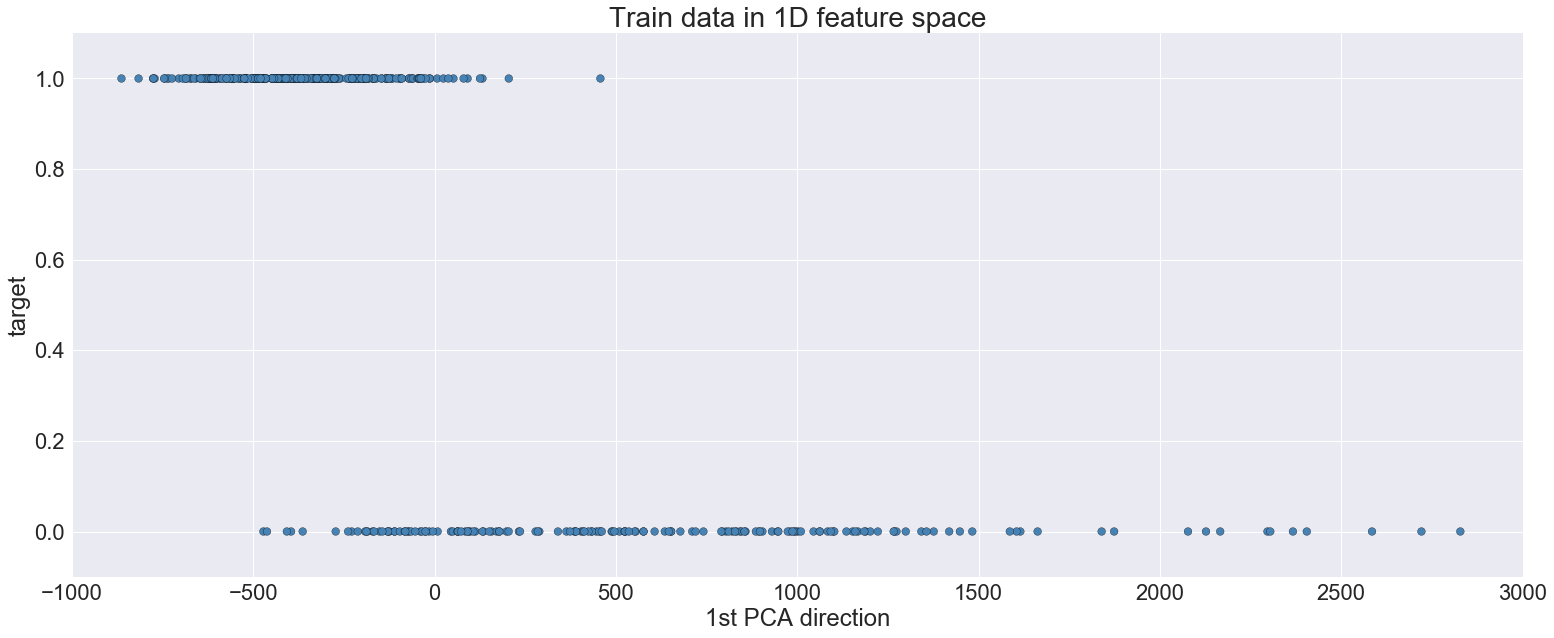

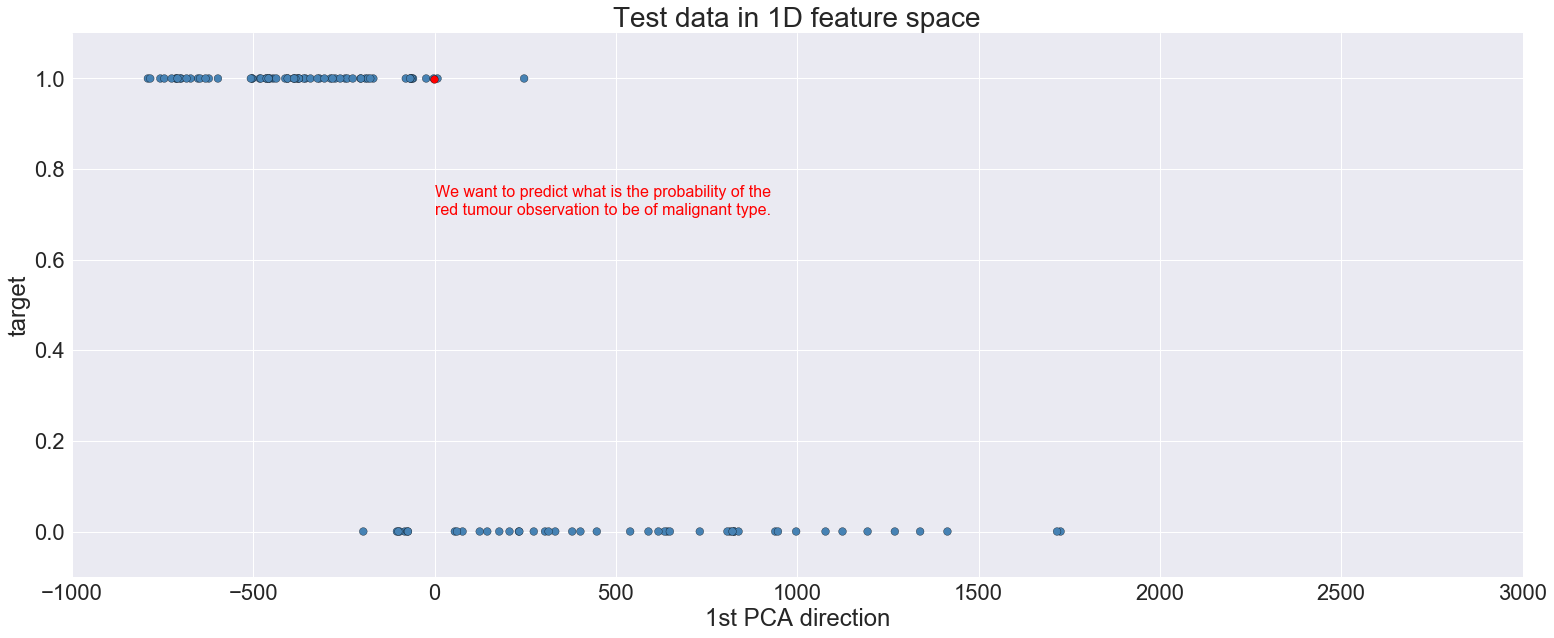

In [8]:
from sklearn.model_selection import train_test_split

# Set test size of 20%
test_size = 0.20

# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = test_size)

plot_1d(X_train, y_train, title = 'Train data in 1D feature space'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
       ,xlims = [-1000, 3000])    

plot_1d(X_test, y_test, title = 'Test data in 1D feature space'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]        
       ,xlims = [-1000, 3000]
       ,featured = 1);

Next we want to fit the logistic regression model to data. The logistic regression model is similar to ordinary linear regression, but whereas in ordinary linear regression we directly regress the target variable <i>y</i>, in logistic regression we regress the probability of the observation belonging to to certain target class. To build up the intuition, consider first the <b>logistic function</b> $\sigma(z)$ having the form

\begin{align*}
\sigma(z) &= \frac{e^{z}}{e^{z} + 1}
\end{align*}

Logistic function has an S-like shape and it squeezes any given input value $z$ between 0 and 1. Example plotted below for values of z in the interval $[-5, 5]$. Since the values of logistic functions are constrained between 0 and 1, it can be interpreted as outputting a probability value <i>p</i>. That is, $p = \sigma(z)$

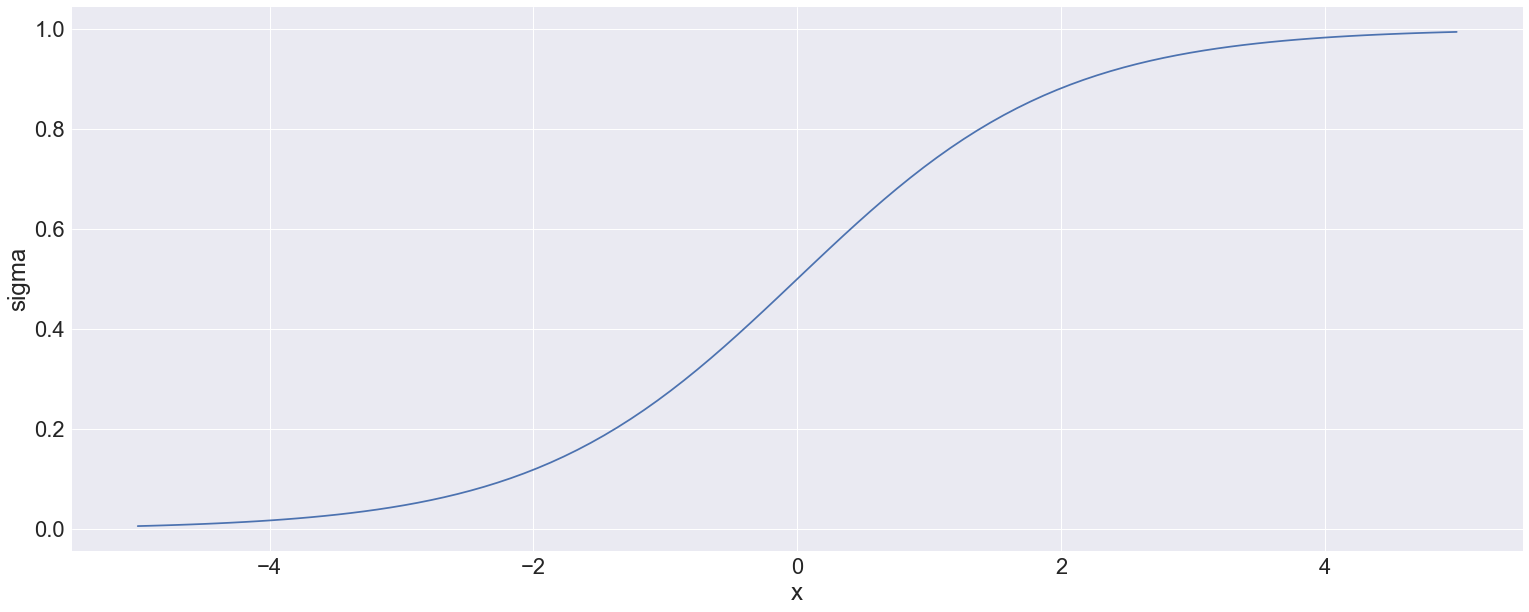

In [9]:
x = np.linspace(-5, 5, 100)
sigma = np.exp(x) / (1 + np.exp(x))
plot_sigmoid(x,sigma)

Recall the linear regression equation
\begin{align*}
y = F(\mathbf{x}) = \mathbf{x} '  \mathbf{\beta}
\end{align*}


Taking only 1st principal component into consideration, when fit to our training data using least-squares minimization, draws a line through the observations in two-dimensional plane where the 1st PC is on x-axis and our binary target variable is on y-axis: 



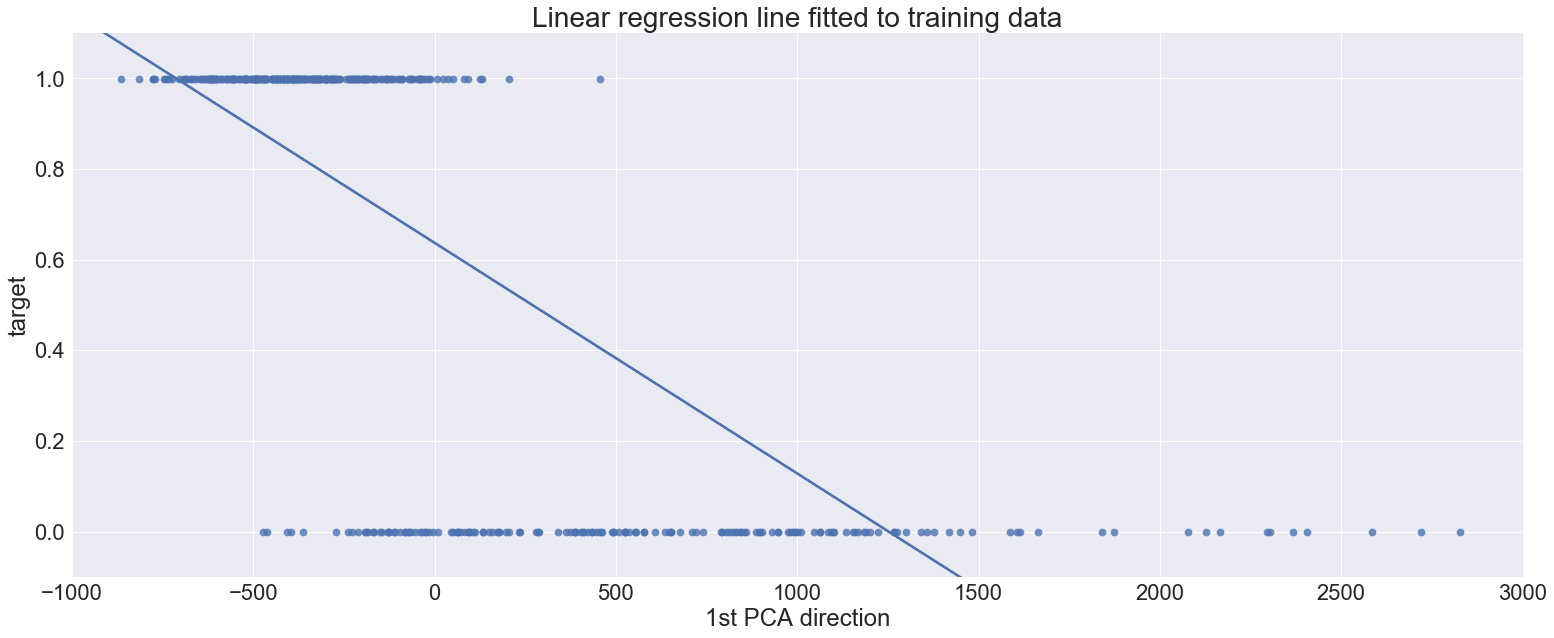

In [10]:
df_temp = pd.DataFrame({'x':X_train[:,0], 'y':y_train})
plot_linreg(df_temp)

Compared to linear regression equation, in logistic regression the term on the left-hand side of the regression equation is the so-called <b>logit</b> (or <i>log-odds</i>):

\begin{align*}
logit(p) = ln \big( \frac{p}{1-p} \big) = \mathbf{x} '  \mathbf{\beta}
\end{align*}

It is relatively easy to check that the inverse of logit is just the logistic function:

\begin{align*}
p = \sigma(\mathbf{x}) = \frac{e^{\mathbf{x}'\beta}}{e^{\mathbf{x}'\beta} + 1}  
\end{align*} 

That is, instead of regressing the target variable values as in linear regression, <b>in logistic regression we regress the logit which is inverse of the logistic function</b>. The link between linear regression becomes clear: applying logistic function to the right-hand side of the linear regression equation (with ) effectively squisches the regression line to beboubded between interval $[0,1]$. Thus, the output of logistic regression can be interpreted as a probability:

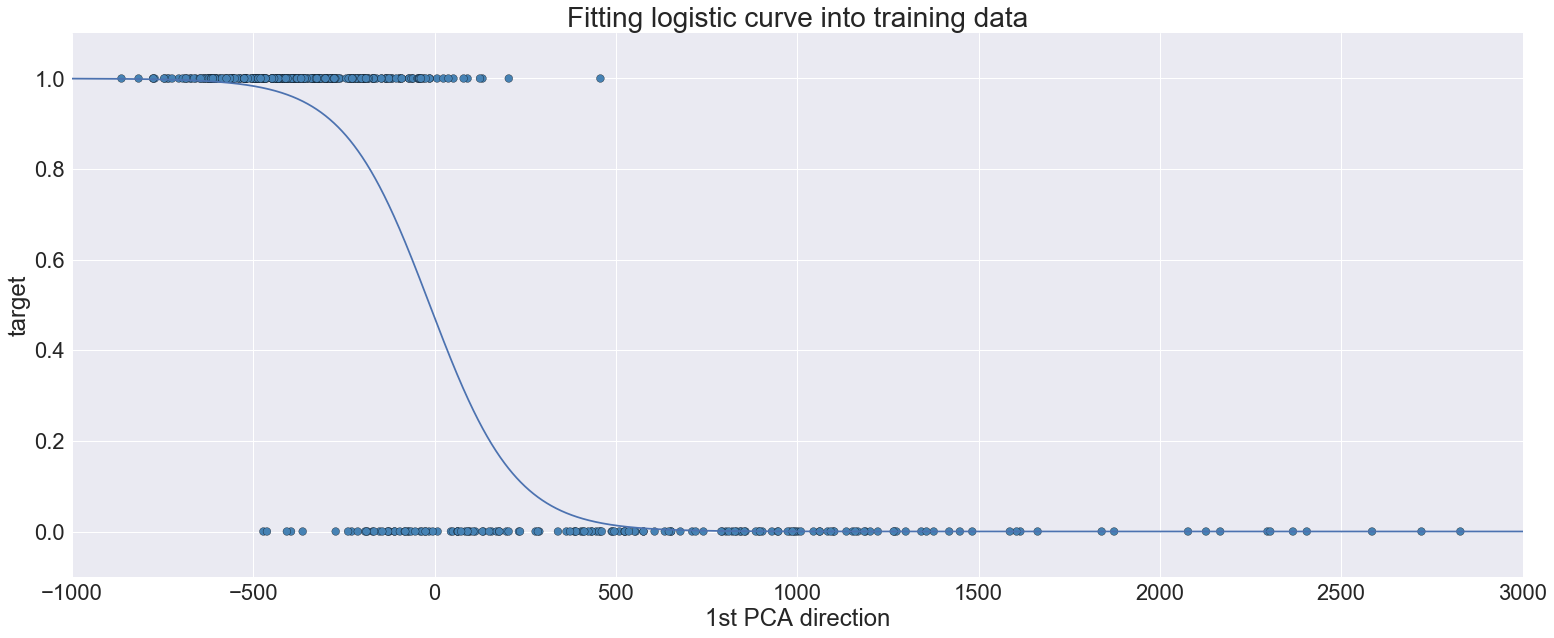

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Pick only one feature
exog = X_train[:,0].reshape((len(X_train),1))

# Scikit learn for accuracy
C = 1e9
model = LogisticRegression(C = C, fit_intercept = True, penalty = 'l1')
model.fit(exog, y_train)
y_pred_1d = model.predict(X_test[:,0].reshape((len(X_test),1)))
y_probs_1d = model.predict_proba(X_test[:,0].reshape((len(X_test),1)))
#print('scikit learn intercept {0:.5f} and coefficient {1:.5f}: '.format(model.intercept_[0], model.coef_[0,0]))

# statsmodel for p-values
import statsmodels.api as sm
endog = y_train
exog = sm.add_constant(exog)
logit = sm.Logit(endog, exog)
logit_res = logit.fit(disp=0)

# plot
x_ax = np.linspace(-1000.0, 4000.0, num = 5000)
y_ax = np.exp(model.intercept_[0] + model.coef_[0,0] * x_ax) / (1 + np.exp(model.intercept_[0] + model.coef_[0,0] * x_ax))

plot_1d(X_train, y_train, title = 'Fitting logistic curve into training data'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
       ,log_curve = [x_ax, y_ax],xlims = [-1000, 3000])    

We can display the results from the logistic regression in a table. We see that the 1st principal component is statistically significant whereas the intercept is not.

In [12]:
display(logit_res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  455
Model:                          Logit   Df Residuals:                      453
Method:                           MLE   Df Model:                            1
Date:                Fri, 22 Jun 2018   Pseudo R-squ.:                  0.6464
Time:                        22:04:11   Log-Likelihood:                -105.35
converged:                       True   LL-Null:                       -297.99
                                        LLR p-value:                 8.868e-86
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1113      0.209     -0.533      0.594      -0.521       0.298
x1            -0.0084      0.001     -8.982      0.000      -0.010      -0.007
==============================================================================
"""

Let's take a closer look at the featured observation which we colored red earlier. We can draw a vertical line from this observation which crosses the fitted logistic curve at certain point. The point of crossing of the curves tells the <b>model implied probability of the featured observation beign of benign type (target = 1)</b>. The probability of the featured observation being malignant is of course 1 minus this value. In this case our model assigns a probability of 52.1% of the observation being a malignant tumour although the correct label for the observation in question is benign!

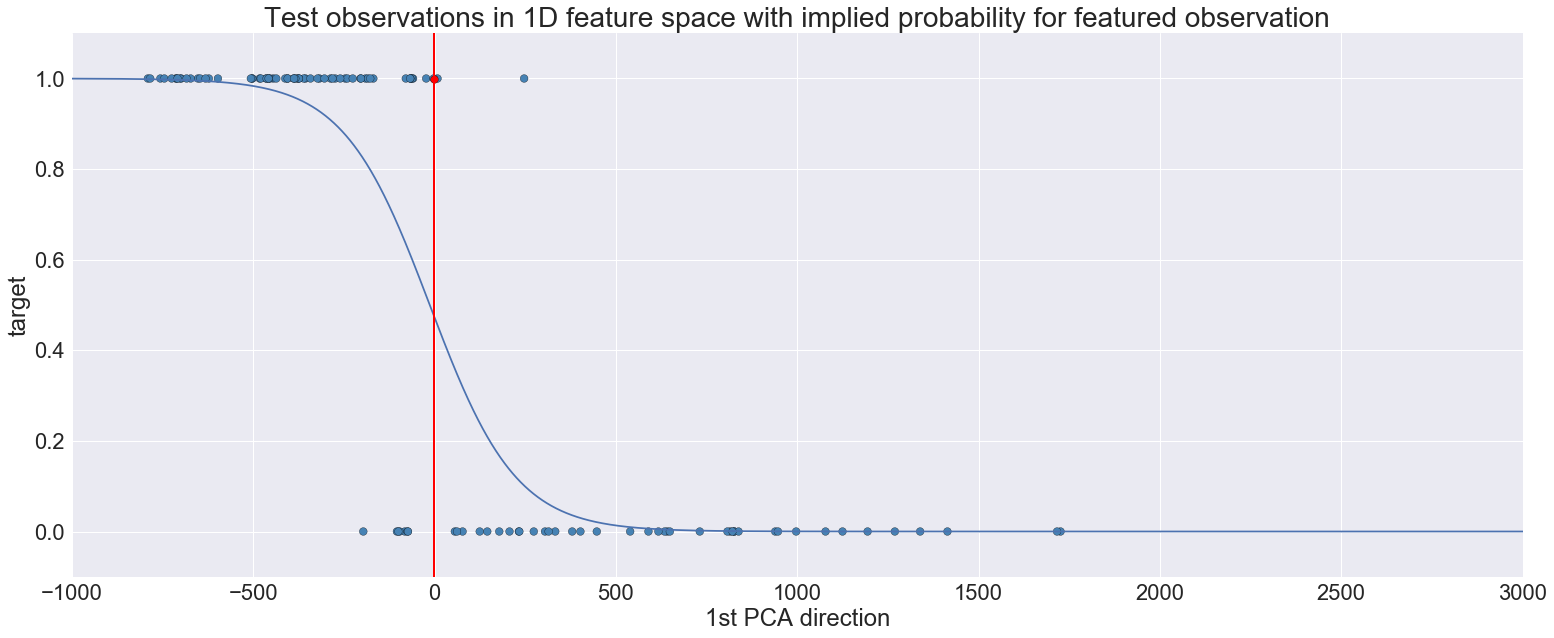

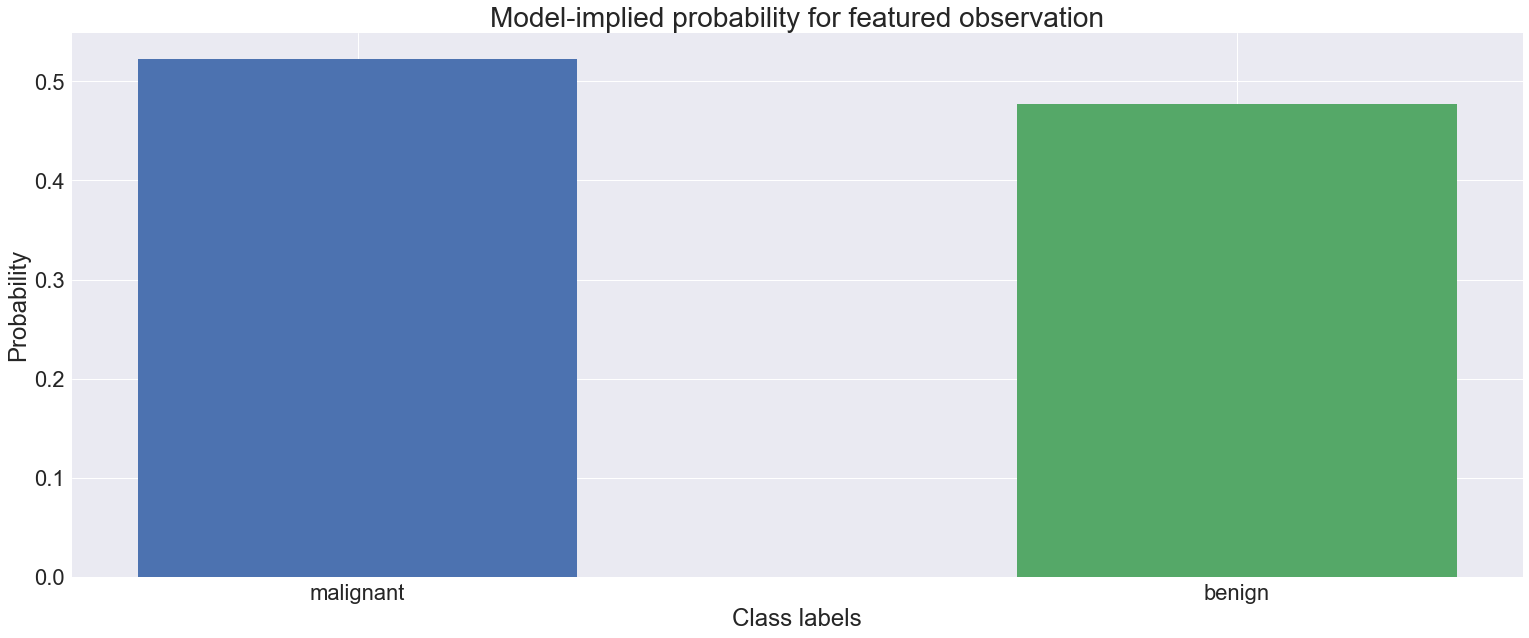

In [13]:
plot_1d(X_test, y_test, title = 'Test observations in 1D feature space with implied probability for featured observation'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
       ,log_curve = [x_ax, y_ax]
       ,xlims = (-1000, 3000)
       ,featured = 2)   

plot_bars(y_probs_1d, 113)    

## Evaluating 1-feature model performance

Now that we have built a model that can predict the probability of a tumour observation being either malignant or benign, we want to evaluate how well it performs. This is done by combining the model with a <b>decision rule</b> which turns our logistic regression model into a <b>classifier</b>. 



Classification means identifying to which of a set of categories a new observation belongs. Say we decide that every test observation with predicted probability over 50% of being malignant is classified as malignant, and rest classified as benign. Then we haev essentially assigned a decision rule of $p = 0.5$ to be used in conjuction with our model. What this means in our one-dimensional feature space plot is that we first draw a vertical line that intersects the fitted logistic curve at $y = 0.5$.

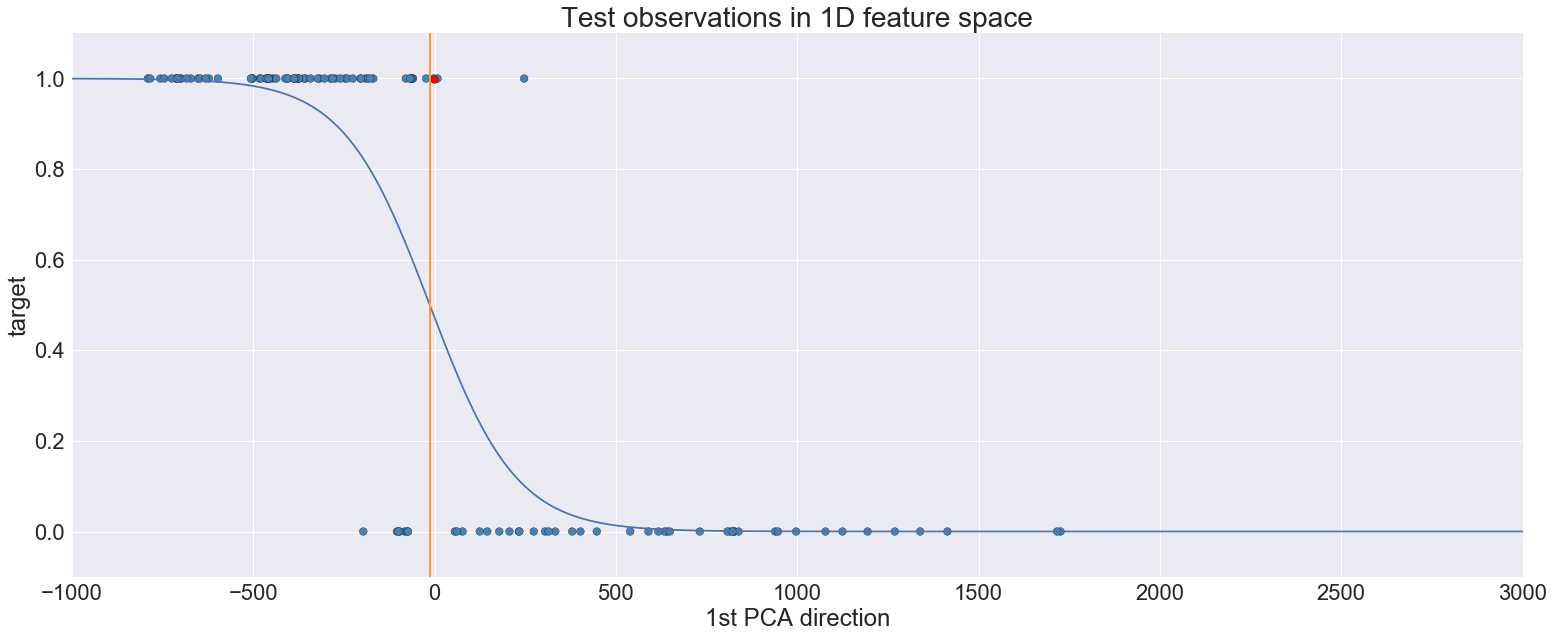

In [14]:
plot_1d(X_test, y_test, title = 'Test observations in 1D feature space'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
       ,log_curve = [x_ax, y_ax]
       ,xlims = (-1000, 3000)        
       ,featured = 4) 

All benign observations (target = 1) that reside to left of the orange vertical line are correctly classified as benign observations (we call these <b>true positives, TP</b>), whereas benign observations to the right of the orange line are incorrectly classified as malignant observations (<b>false negatives, FN</b>). Conversely, malignant observations (target = 0) that reside to the right of the orange line are correctly classified as malignant (<b>true negatives, TN</b>), whereas malignant observations to the left of the orange curve are  incorrectly classified as benign (<b>false positives, FP</b>). As we see, our featured (beningn) observation is incorrectly classified as malignant as it resides on the right-hand side of the orange line.

When we run all test samples through our classifier, with <b>confusion matrix</b> we can keep track how many TP/FN/TN/FN's we got. As a rule of thumb, the more correct predictions (TP/TN) we receive over false predictions (FP/FN) the better. For more in-depth analysis, there exists many different metrics with which to evaluate the predictive power of a model. It depends on the application which of the different metrics is the most appropriate, but maybe the most often used is <b>accuracy</b> (Acc), defined as

\begin{equation}
Acc = \frac{TP + TN}{TN + TP + FN + FP}
\end{equation}

As we can  see, accuracy measures the ratio of correct predictions to all predictions made. The more we correct predictions, the higher the accuracy. In the image below we see that our 1-featured model fairs with accuracy of 0.912.

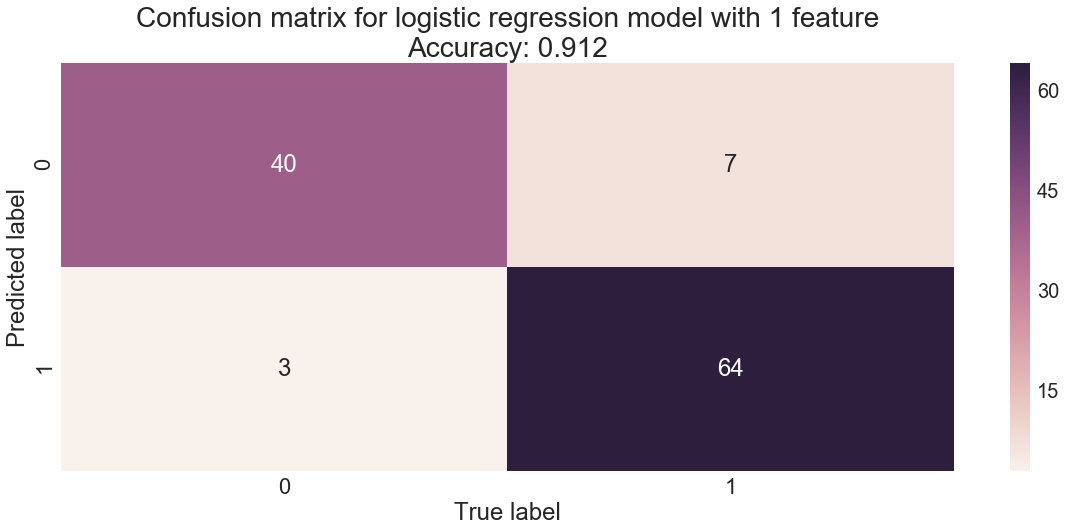

In [15]:
plot_confusion_matrix(y_test, y_pred_1d, title = 'Confusion matrix for logistic regression model with 1 feature')

In [16]:
# Below cell is not important, used only to store variables for visualization video.
# Save plots for animations
#fig = plot_1d(X_test, y_test, title = 'Test observations in 1D feature space'
#       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
#       ,log_curve = [x_ax, y_ax]
#       #,xlims = (-1363.14230778, 4367.17805308)
#       ,xlims = (-1000, 2000)        
#       ,featured = 4
#       ,style = 'animation') 
#fig.savefig('animation_1dresult.svg', facecolor=fig.get_facecolor(), format='svg', dpi=1200)
#
#fig = plot_confusion_matrix(y_test, y_pred_1d, title = 'Confusion matrix for logistic regression model with 1 feature', style = 'animation')
#fig.savefig('animation_1dconfusionmatrix.svg', facecolor=fig.get_facecolor(), format='svg', dpi=1200)

## Model with two features

Let us now introduce the second principal component as the second feature to our model. First we plot the full data set in the 2-dimesnional feature space. x-axis still exhibits the 1st PC and y-axis now becomes the 2nd PC. Target variable (having either value 0 or 1) is designated by the color of the blob. We divide the data into train and test samples as in 1-dimensional feature space case.

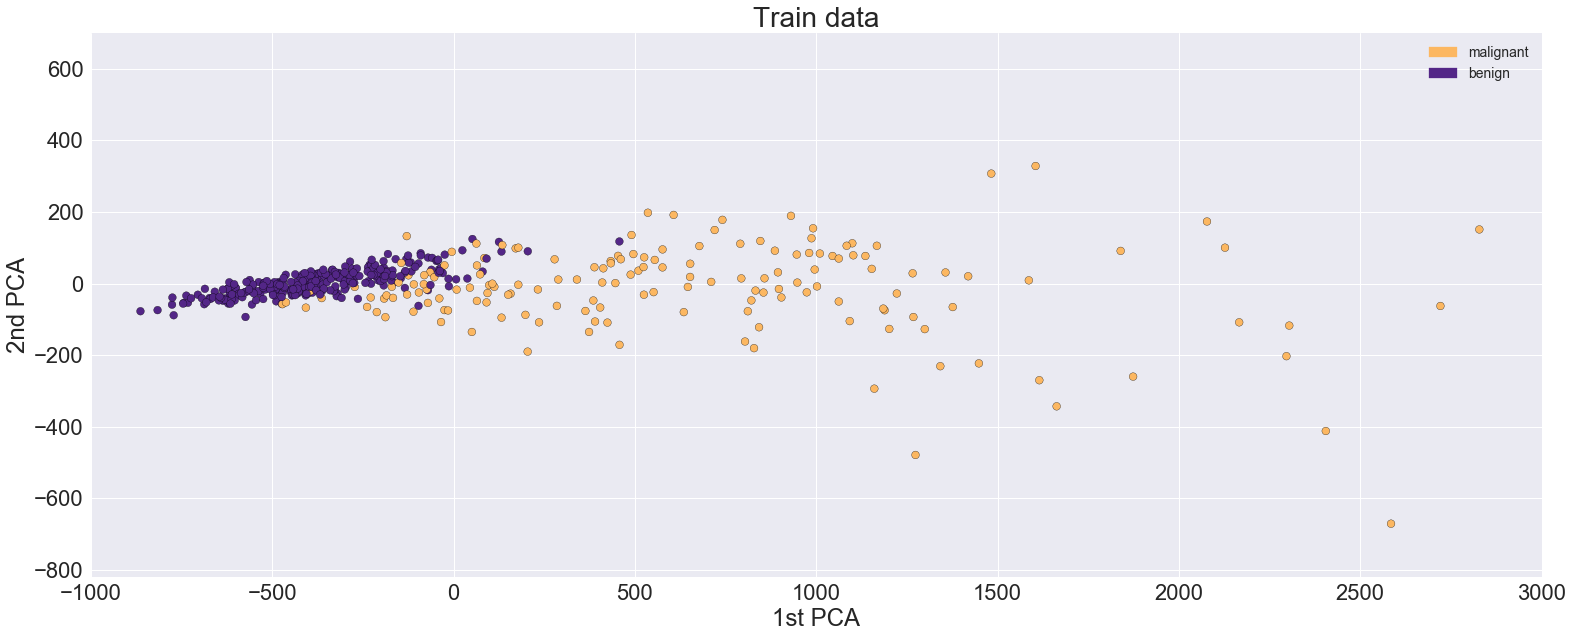

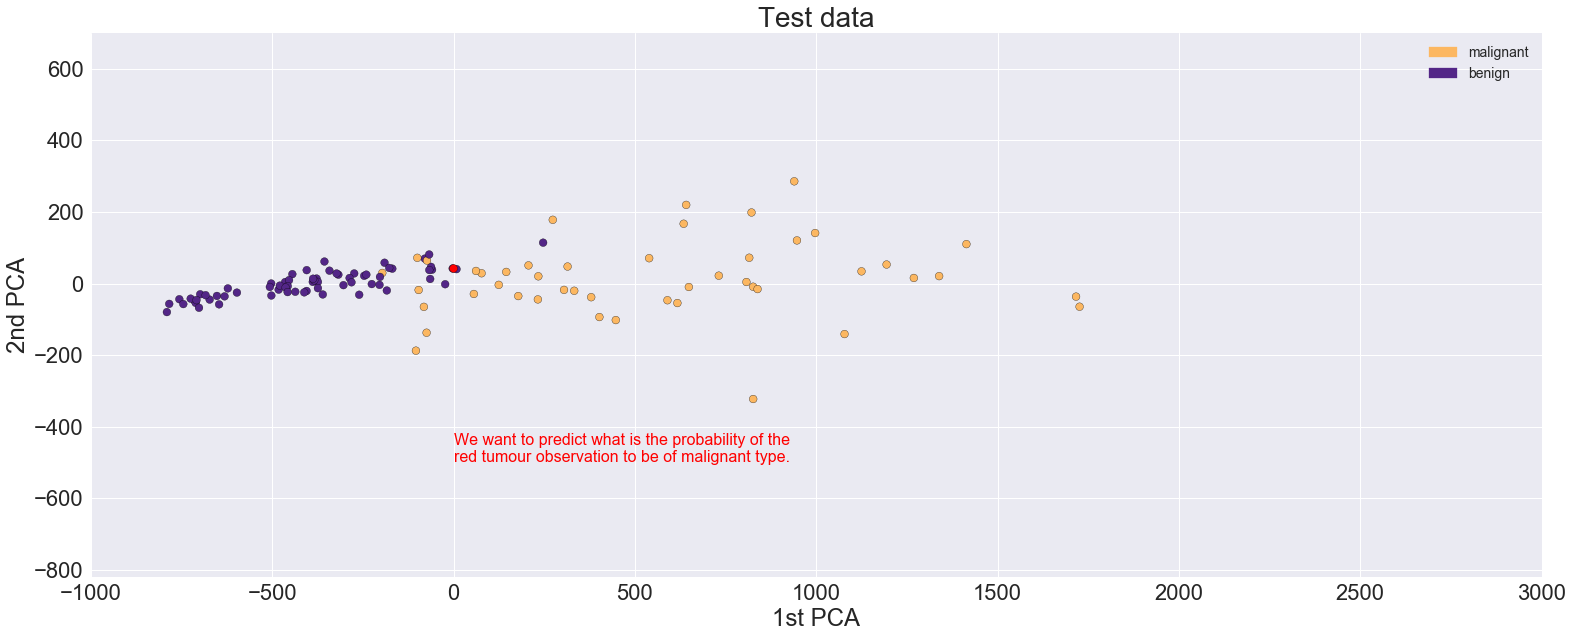

In [17]:
plot_2d(X_train, y_train, title = 'Train data'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
        ,lims = (-1000, 3000, -820, 700))

plot_2d(X_test, y_test, title = 'Test data'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]], featured = 1
       ,lims = (-1000, 3000, -820, 700));

Let us fit the two feature model. We will plot a similar grpah as the sigmoid curve above but this time in two-dimensional feature space. We use color intensity to designate the probability of a given point to be predicted either as malignant or benign. The darker the background color, the higher the predicted probability of either class memebership. Along the white fjord the probability of an obseravtion being malignant is about 50%, meaning that here the model is unsure about its prediction.

Optimization terminated successfully.
         Current function value: 0.172227
         Iterations 9


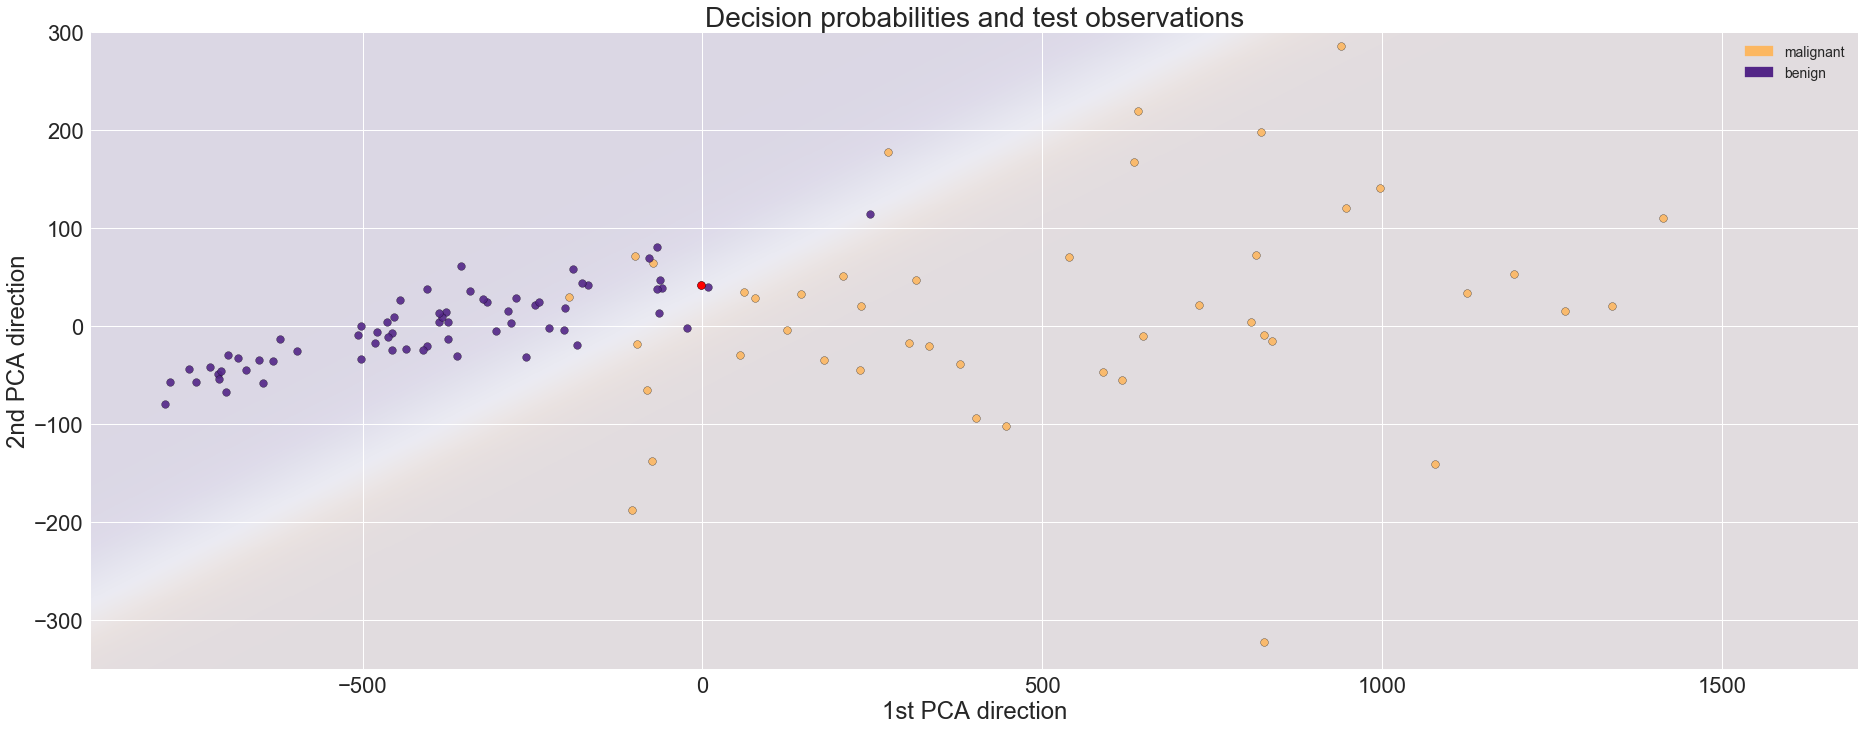

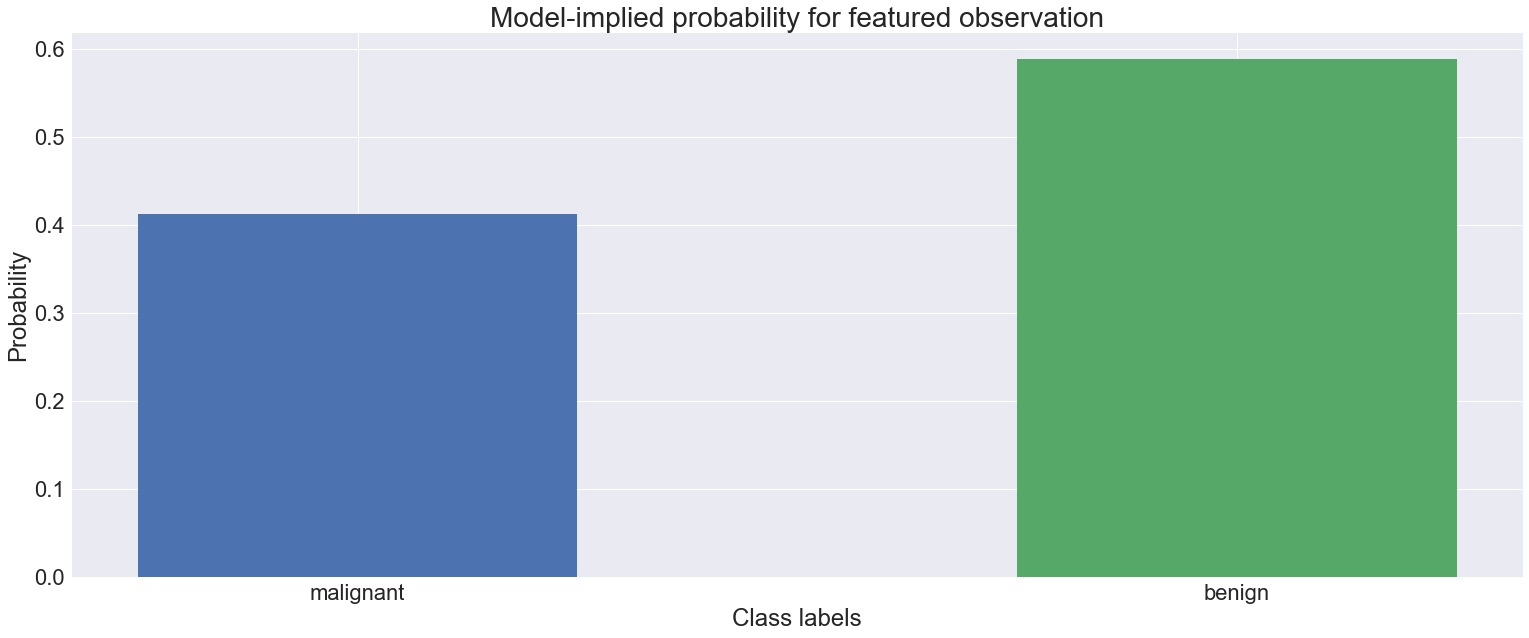

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Scikit learn for accuracy
C = 1e9
model = LogisticRegression(C = C)
model.fit(X_train, y_train)
y_pred_2d = model.predict(X_test)
y_probs_2d = model.predict_proba(X_test)
#print('scikit learn estimates',model.intercept_, model.coef_)

# statsmodel for p-values
import statsmodels.api as sm
endog = y_train
exog = sm.add_constant(X_train)
logit = sm.Logit(endog, exog)
logit_res = logit.fit()

# Plot in 2-dimensional feature space 
plot_bin_decision_probs(X_test, y_test, model
                        ,class_names = [dataset.target_names[0], dataset.target_names[1]]
                        ,title = 'Decision probabilities and test observations'
                        ,mesh_step_size = 1, correction = 500
                        ,featured = 1
                        ,lims = (-900, 1700, -350, 300))

plot_bars(y_probs_2d, 113)

Displaying regression results we see that both principal components are statistically significant.

In [19]:
# display regression results
display(logit_res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  455
Model:                          Logit   Df Residuals:                      452
Method:                           MLE   Df Model:                            2
Date:                Fri, 22 Jun 2018   Pseudo R-squ.:                  0.7370
Time:                        22:04:14   Log-Likelihood:                -78.363
converged:                       True   LL-Null:                       -297.99
                                        LLR p-value:                 4.147e-96
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1432      0.338     -3.382      0.001      -1.806      -0.481
x1            -0.0122      0.001     -8.597      0.000      -0.015      -0.009
x2             0.0347      0.006      5.972      0.000       0.023       0.046
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

We can again use the 0.5 probability decision rule to use the trained logistic regression model as classifier. Whereas in the 1-feature case the decision boundary was a vertical line, here it is an affine line in the 2 dimensional space. As we can see, the featured observation is now classified as benign. Further, looking at the confusion matrix we can see that our model performs overall better; Accuracy has increased to 0.947 as the amount of false positives has decreased by 3 and false negatives by one. We can deduce that the model built with two features works better than the model with just one feature.

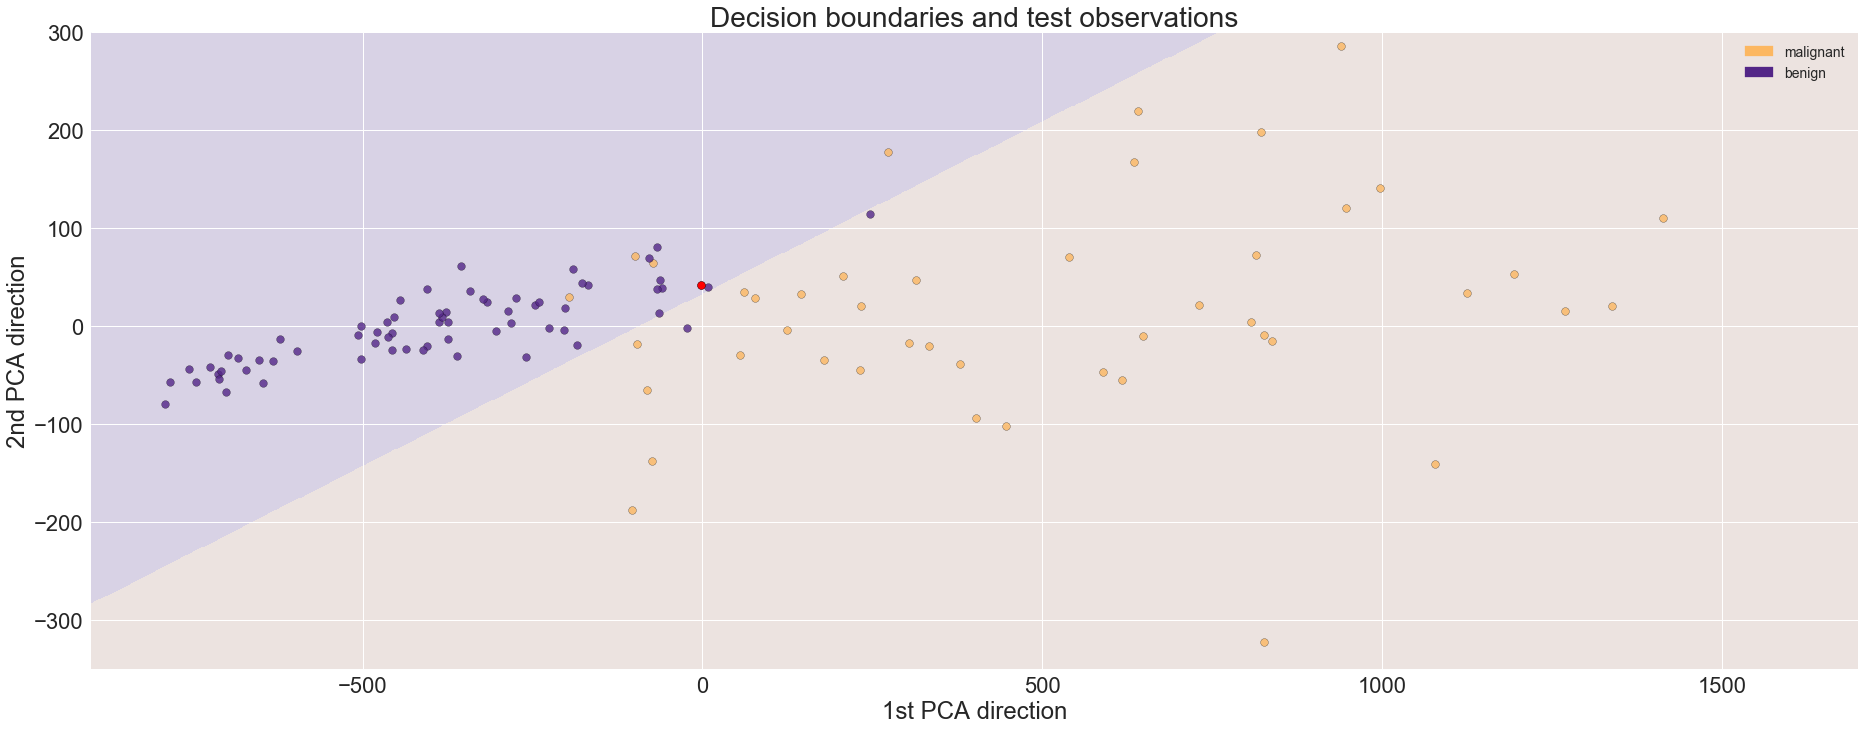

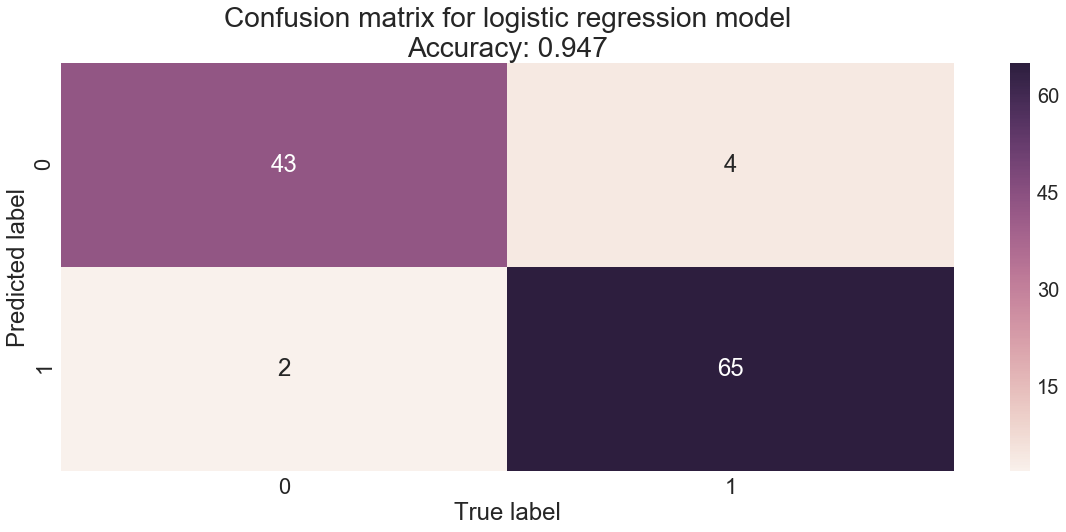

In [23]:
plot_decision_boundaries(X_test, y_test, model, class_names = [dataset.target_names[0], dataset.target_names[1]], title = 'Decision boundaries and test observations', mesh_step_size = 1, correction = 500, featured = 1
                        ,lims = (-900, 1700, -350, 300))

plot_confusion_matrix(y_test, y_pred_2d, title = 'Confusion matrix for logistic regression model')

In [22]:
# Below cell is not important, used only to store variables for visualization video.
# Save plots for animations
#fig = plot_decision_boundaries(X_test, y_test, model, title = 'Decision boundaries and test observations', mesh_step_size = 1, correction = 500, featured = 0, style = 'animation') 
#fig.savefig('animation_2dresult.svg', facecolor=fig.get_facecolor(), format='svg', dpi=300)
#
#fig = plot_confusion_matrix(y_test, y_pred_2d, title = 'Confusion matrix for logistic regression model with 2 features', style = 'animation')
#fig.savefig('animation_2dconfusionmatrix.svg', facecolor=fig.get_facecolor(), format='svg', dpi=1200)

## Conclusion

Conclusion here